In [6]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [4]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [5]:
data_path  = '../data/'

In [6]:
slack = SlackDataLoader(path='../data/')

In [7]:
channels = slack.get_channels()

In [8]:
users = slack.get_users()

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [9]:

    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [10]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()
    

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [11]:
# which user has the highest number of reply counts

user_reply_map = {}

for ch in channels:
    mpData = utils.get_community_participation(f"{data_path}{ch['name']}/")
    for user, reply_count in mpData.items():
        user_reply_map[user] = user_reply_map.get(user, 0) + reply_count
    

sorted_user_reply_map = dict(sorted(user_reply_map.items(), key=lambda item: item[1], reverse=True))

   
# Get the first key-value pair
highest_user_id, highest_reply_count = next(iter(sorted_user_reply_map.items()))


#get name_id from group

user_names = {user['id']: user['name'] for user in slack.get_users()}
highest_user_name = user_names.get(highest_user_id, "Unknown")
      
# Print the result
print(f"The user with the highest number of reply counts is {highest_user_name} with a count of {highest_reply_count}.")

The user with the highest number of reply counts is Amy with a count of 736.


In [12]:
# which user has the highest number of Message count?

merged_mesage_df = pd.DataFrame(columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type','time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end'])

for channel in channels:
    channel_name = channel['name']
    mp_data = utils.slack_parser(f"{data_path}{channel_name}/")
    merged_mesage_df = pd.concat([merged_mesage_df, mp_data])
    
user_counts = merged_mesage_df['sender_name'].value_counts()

# Get the user with the highest count
highest_user = user_counts.idxmax()
user_counts_df = pd.DataFrame({'User': user_counts.index, 'Message Count': user_counts.values})

# Print the table
print(user_counts_df)
print("User with the highest number of messages:", highest_user)

                User  Message Count
0     Vanessa Norman           1288
1           Amy Leon           1150
2      Travis Butler           1075
3        April Lucas            991
4   Brenda Hernandez            843
..               ...            ...
57  Christopher Case              1
58       Blake Scott              1
59       Erica Munoz              1
60    Holly Whitaker              1
61       David Scott              1

[62 rows x 2 columns]
User with the highest number of messages: Vanessa Norman


In [13]:
# which user has the highest number of number of Mention?

result_list = []

for channel in channels:
    channel_name = channel['name']
    mp_data = utils.slack_parser(f"{data_path}{channel_name}/")
   
    result = [
    utils.get_tagged_users(mp_data)
    .apply(lambda x: x if x else None)  # Replace empty lists with None
    .dropna()
    .tolist()
    ]
    
    result_list.extend(item for sublist in result for item in sublist)
     


# list of Mention
flattened_list = [mention for sublist in result_list for mention in sublist]

mention_df = pd.DataFrame(flattened_list, columns=['Mention'])


mention_counts = mention_df['Mention'].value_counts()

sorted_mention_counts = mention_counts.sort_values(ascending=False)
# Display the sorted counts
highest_user_id = sorted_mention_counts.index[0].replace('@', '')
reaction_count = sorted_mention_counts.iloc[0]

user_names = {user['id']: user['name'] for user in slack.get_users()}
highest_user_name = user_names.get(highest_user_id, "Unknown")
      
# Print the result
print(f"The user with the highest number of Mention counts is {highest_user_name} with a count of {reaction_count}.")
print(sorted_mention_counts)

The user with the highest number of Mention counts is Vanessa with a count of 190.
Mention
@U03V1AM5TFA    190
@U03TEPYRM2P    180
@U03UUR571A5    174
@U03UVHCV6KB    170
@U03UKL27B0R    169
@U03UG32J3PC    168
@U03UJGP0C68    135
@U03UG4Q7V42    134
@U03UD68RQH3    129
@U03UJKJGRAQ    122
@U03V6HMRPGQ     96
@U03U1HAG9TR     90
@U03U9DB7REG     83
@U03U1FNPEUX     83
@U03V8LHPDME     80
@U03V785NLSU     78
@U03UH397319     73
@U03UP7V9Q57     68
@U03UUN8M4RX     61
@U03UJGRN5E0     59
@U03UD4FEDHB     58
@U03U93GNNVB     55
@U03UUP56MDF     52
@U03U9FWPNCE     52
@U03UJN29Y4C     51
@U03T89ACUUW     49
@U03UG1Z21JP     48
@U03U1GHT39V     47
@U03V61VGQG0     46
@U03U4GULU3Y     44
@U03UUS0MZCZ     42
@U03TT5KEYCF     42
@U03UL5LSTG9     41
@U03UG0SFHGT     35
@U03UFV7HFNF     31
@U03U9EJR362     30
@U03V5Q9N516     29
@U03UD5B7C3X     28
@U03UG0YHAUT     26
@U03TX2VN6H5     24
@U03UJH1EQQL     21
@U03U1J51VFZ     20
@U03UHB8CXDY     20
@U03UUMR26Q1     20
@U03UFV7TUTV     20
@U03UG5VF

In [22]:
# which user has the highest number of Reaction count?
# use this parse_slack_reaction(path, channel) from utls and get reaction count
columns_reaction = pd.DataFrame(columns=['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id'])
for channel in channels:
    channel_name = channel['name']
    mp_data = utils.parse_slack_reaction(f"{data_path}{channel_name}/",channel_name )
    columns_reaction = pd.concat([columns_reaction, mp_data], ignore_index=True)

# now that we have all reactions and users from all the channels
# Group by 'user_id' and sum the 'reaction_count'
user_reaction_counts = columns_reaction.groupby('user_id')['reaction_count'].sum().reset_index()

sorted_user_reaction_counts = user_reaction_counts.sort_values(by='reaction_count', ascending=False)

highest_user_id, reaction_count = sorted_user_reaction_counts.iloc[0]
      
user_names = {user['id']: user['name'] for user in slack.get_users()}
highest_user_name = user_names.get(highest_user_id, "Unknown")


# Print the result
print(f"The user with the highest number of Reaction count is {highest_user_name} with a count of {reaction_count}.")
#print(sorted_user_reaction_counts)

The user with the highest number of Reaction count is Vanessa with a count of 1124.


In [15]:
#What are the top 10 messages by ■ Replies?


merged_mesage_df = pd.DataFrame(columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type','time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end'])

for channel in channels:
    channel_name = channel['name']
    mp_data = utils.slack_parser(f"{data_path}{channel_name}/")
    
    merged_mesage_df = pd.concat([merged_mesage_df, mp_data])
    


# Convert 'reply_count' to numeric for proper sorting
merged_mesage_df['reply_count'] = pd.to_numeric(merged_mesage_df['reply_count'])

# Sort the DataFrame by 'reply_count' in descending order
sorted_df = merged_mesage_df.sort_values(by='reply_count', ascending=False)

# Display the sorted DataFrame
print(sorted_df[['msg_content', 'reply_count']].head(10))

                                            msg_content  reply_count
7208          <@U03V1AM5TFA> how many crushes you have?           75
975   First Impression: People think I am older than...           63
209   1. How do I find my jupyter notebook file in m...           61
1546  How many here follow football so much? I think...           57
60                      Ethiopian New year Loading ....           54
284   Hello\n1. <@U03UVHCV6KB>\n2. <@U03UG5VFN03>\n3...           45
83    <@U03UUR571A5> Solutions to funding account an...           44
148   We had a plan to meet today 2:00 EAT at Friend...           36
379   *<!here> REMINDER*:timer_clock:\n\n*Please not...           33
6843  the debate was great. We <@U03U1J51VFZ>, <@U03...           31


In [16]:
#What are the top 10 messages by ■ Reactions?


# use this parse_slack_reaction(path, channel) from utls and get reaction count
columns_reaction = pd.DataFrame(columns=['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id'])
for channel in channels:
    channel_name = channel['name']
    mp_data = utils.parse_slack_reaction(f"{data_path}{channel_name}/",channel_name )
    columns_reaction = pd.concat([columns_reaction, mp_data], ignore_index=True)


# Convert 'reply_count' to numeric for proper sorting
columns_reaction['reaction_count'] = pd.to_numeric(columns_reaction['reaction_count'])

# Sort the DataFrame by 'reply_count' in descending order
sorted_df = columns_reaction.sort_values(by='reaction_count', ascending=False)

# Display the sorted DataFrame
print(sorted_df[['message', 'reaction_count']].head(10))

                                                message  reaction_count
4695  Good morning winners, welcome to week 9 of wee...              17
2138  My reactions when am not finished the task bef...              16
249                                                                  16
4085  Little known fact - all 10 Academy technical t...              16
1322  *Guys <!here>.... Make sure to come back from ...              15
4468  Welcome to week6 everyone. By Friday, we’ll be...              15
1444  *Here are some other stories from people that ...              15
1404  1- let me open my VPN, where do you want me to...              14
3245  <!channel>\nThere will be no careers exercise ...              14
1640  3 things I dont want him to know:\n\n1. That I...              13


In [17]:
#What are the top 10 messages by ■ Mentions?

columns_reaction = pd.DataFrame(columns=['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id'])
for channel in channels:
    channel_name = channel['name']
    mp_data = utils.parse_slack_reaction(f"{data_path}{channel_name}/",channel_name )

    columns_reaction = pd.concat([columns_reaction, mp_data], ignore_index=True)


# Convert 'reply_count' to numeric for proper sorting
columns_reaction['reaction_count'] = pd.to_numeric(columns_reaction['reaction_count'])

# Sort the DataFrame by 'reply_count' in descending order
sorted_df = columns_reaction.sort_values(by='reaction_count', ascending=False)

# Display the sorted DataFrame
print(sorted_df[['message', 'reaction_count']].head(10))

                                                message  reaction_count
4695  Good morning winners, welcome to week 9 of wee...              17
2138  My reactions when am not finished the task bef...              16
249                                                                  16
4085  Little known fact - all 10 Academy technical t...              16
1322  *Guys <!here>.... Make sure to come back from ...              15
4468  Welcome to week6 everyone. By Friday, we’ll be...              15
1444  *Here are some other stories from people that ...              15
1404  1- let me open my VPN, where do you want me to...              14
3245  <!channel>\nThere will be no careers exercise ...              14
1640  3 things I dont want him to know:\n\n1. That I...              13


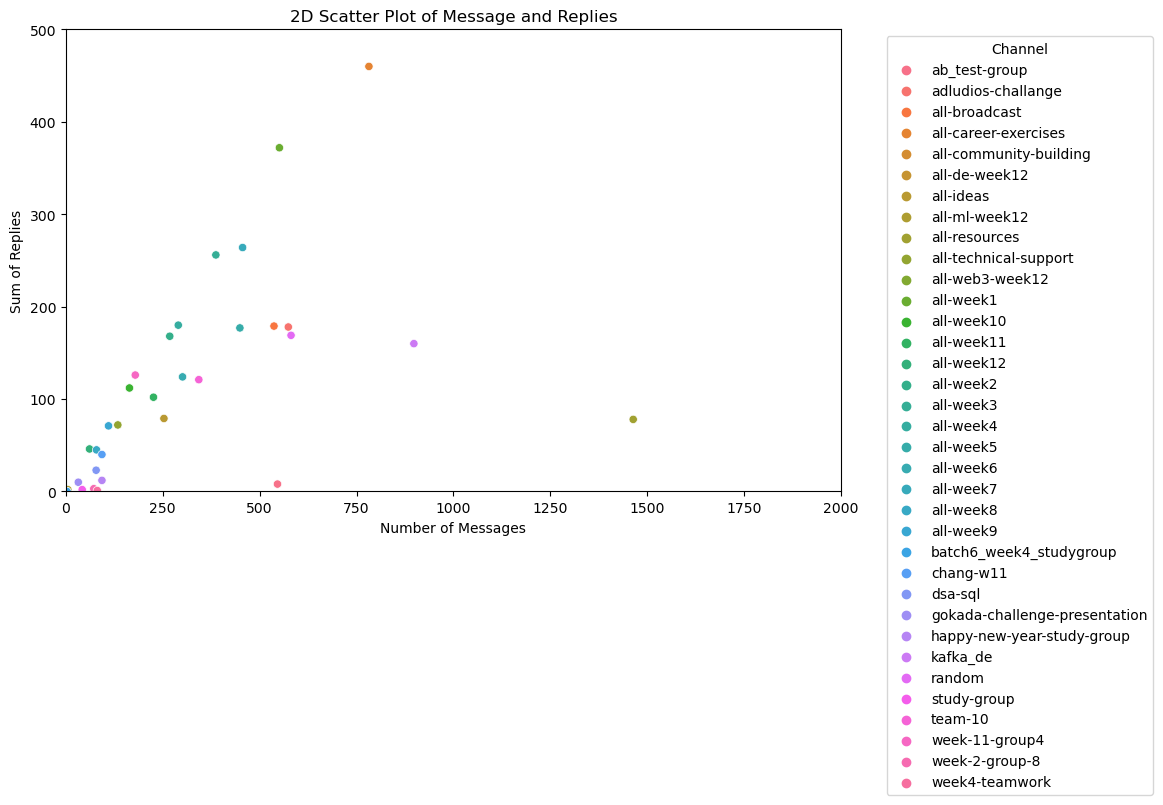

In [18]:
#Which channel appears at the right top corner when you plot a 2D scatter plot where x-axis is the number of messages in

merged_mesage_df = pd.DataFrame(columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type','time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end', 'channel'])

for channel in channels:
    channel_name = channel['name']
    mp_data = utils.slack_parser(f"{data_path}{channel_name}/")
    mp_data['channel'] = channel_name
    merged_mesage_df = pd.concat([merged_mesage_df, mp_data])


channel_stats = merged_mesage_df.groupby('channel').agg({
    'msg_content': 'count',
    'reply_count': 'sum'
}).reset_index()

channel_stats['replies'] = channel_stats['reply_count']

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='msg_content', y='replies', hue='channel', data=channel_stats)
plt.xlim(0, 2000)
plt.ylim(0, 500)
# Find the channel at the top right corner
top_right_channel = channel_stats.sort_values(by=['msg_content', 'replies'], ascending=[False, False]).iloc[0]['channel']

plt.title('2D Scatter Plot of Message and Replies')
plt.xlabel('Number of Messages')
plt.ylabel('Sum of Replies')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [19]:
# which user has the highest number of reply counts?

#use this utils.get_community_participation(f"{dataPath}{channel[2]['name']}/")
#make this for all channels
user_reply_map = {}

for ch in channels:
    mpData = utils.get_community_participation(f"{data_path}{ch['name']}/")
    for user, reply_count in mpData.items():
        user_reply_map[user] = user_reply_map.get(user, 0) + reply_count
    

sorted_user_reply_map = dict(sorted(user_reply_map.items(), key=lambda item: item[1], reverse=True))

   
# for all channels find highest count with user then convert id to name
# Get the first key-value pair
highest_user_id, highest_reply_count = next(iter(sorted_user_reply_map.items()))


#get name_id from group

user_names = {user['id']: user['name'] for user in slack.get_users()}
highest_user_name = user_names.get(highest_user_id, "Unknown")
      
# Print the result
print(f"The user with the highest number of reply counts is {highest_user_name} with a count of {highest_reply_count}.")

The user with the highest number of reply counts is Amy with a count of 736.


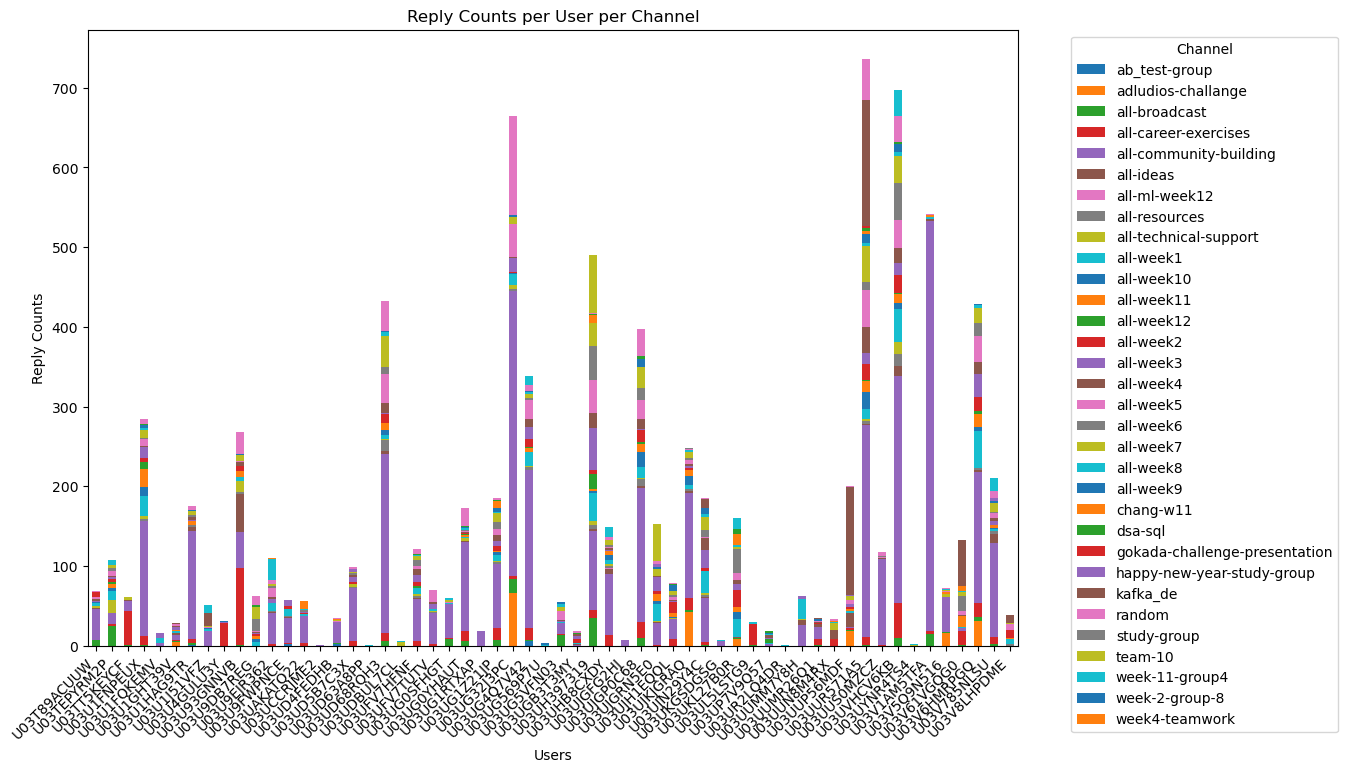

In [20]:
# Visualize reply counts per user per channel
#use this utils.get_community_participation(f"{dataPath}{channel[2]['name']}/")

# construct df and plot

# Initialize a list to store data for each user and channel
data_list = []

# Iterate through channels
for channel in channels:
    channel_name = channel['name']
    mp_data = utils.get_community_participation(f"{data_path}{channel_name}/")

    # Update data_list with counts for the current channel
    for user, reply_count in mp_data.items():
        data_list.append({'User': user, 'Channel': channel_name, 'ReplyCount': reply_count})

# Create a dataframe from the list
df = pd.DataFrame(data_list)

# Pivot the dataframe to have users as rows, channels as columns, and reply counts as values
pivot_df = df.pivot_table(index='User', columns='Channel', values='ReplyCount', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
pivot_df.plot(kind='bar', ax=ax, stacked=True)
ax.set_xlabel('Users')
ax.set_ylabel('Reply Counts')
ax.set_title('Reply Counts per User per Channel')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [21]:
import warnings
warnings.filterwarnings('ignore')
# what is the time range of the day that most messages are sent?

merged_df = pd.DataFrame(columns=['timestamp'])


#loop though channels
for channel in channels:
    channel_name = channel['name']
    mp_data = utils.get_messages_from_channel(f"{data_path}{channel_name}/")
    for a in mp_data['ts']:
        # Convert the list to a DataFrame
        df = pd.DataFrame({'timestamp': pd.to_datetime(a, unit='s')})
        # Concatenate the current DataFrame to the merged DataFrame
        merged_df = pd.concat([merged_df, df], ignore_index=True)


# Sort the DataFrame based on the timestamp
merged_df = merged_df.sort_values(by='timestamp')

# Calculate the time differences between consecutive messages
merged_df['time_diff'] = merged_df['timestamp'].diff()

# Find the index of the maximum time difference (largest gap)
max_gap_index = merged_df['time_diff'].idxmax()

# Extract the start and end timestamps of the time range with the largest gap
start_time = merged_df.loc[max_gap_index, 'timestamp']
end_time = merged_df.loc[max_gap_index + 1, 'timestamp']

# Print the result
print(f"The largest gap in messages occurred between {start_time} and {end_time}")

Number of messages in channel: 79
Number of messages in channel: 29
Number of messages in channel: 73
Number of messages in channel: 84
Number of messages in channel: 81
Number of messages in channel: 66
Number of messages in channel: 15
Number of messages in channel: 83
Number of messages in channel: 3
Number of messages in channel: 8
Number of messages in channel: 11
Number of messages in channel: 1
Number of messages in channel: 8
Number of messages in channel: 5
Number of messages in channel: 18
Number of messages in channel: 8
Number of messages in channel: 2
Number of messages in channel: 4
Number of messages in channel: 3
Number of messages in channel: 9
Number of messages in channel: 1
Number of messages in channel: 7
Number of messages in channel: 8
Number of messages in channel: 7
Number of messages in channel: 13
Number of messages in channel: 7
Number of messages in channel: 7
Number of messages in channel: 8
Number of messages in channel: 8
Number of messages in channel: 1

In [11]:
# Relationship between # of messages and # of reactions


In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?